In [ ]:
!pip install -q pyomo

In [ ]:
# https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/01.02-Running-Pyomo-on-Google-Colab.html#installing-pyomo-and-solvers
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

In [ ]:
import numpy as np
import pyomo
from pyomo.opt import SolverStatus, TerminationCondition
from pyomo.environ import *
import time

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import os
pwd = '/Your/current/path'
pwd = '/content/drive/MyDrive/Colab Notebooks/Fair Fares/INFORMS/Official_Upload/Case_Study'
with open(os.path.join(pwd, 'logistic_18_20_030323.pkl'), 'rb') as f:
    data = pickle.load(f)

### Import Data

In [ ]:
L = data['market_size'].keys()
n = len(L)

In [ ]:
market, b, k, d, t = {}, {}, {}, {}, {}
num = {}
uber_m = 0
service_time_uber = []
for i in L:
  for j in L:
    market[i,j] = data['market_size'].loc[i,j]
    b[i,j] = data['b'].loc[i,j] if i != j else 0
    k[i,j] = data['k'].loc[i,j] if i != j else 0
    d[i,j] = data['avg_dist'].loc[i,j]
    t[i,j] = data['avg_time'].loc[i,j]
    uber_m += data['uber']['num'].loc[i,j] if i != j else 0
    num[i,j] = data['uber']['num'].loc[i,j] if i != j else 0
    service_time_uber.append(data['uber']['sum_service'].loc[i,j] if i != j else 0)

In [ ]:
m = round(sum(service_time_uber)/120)
print('number of cars', m)
print('total market size', sum(market.values()))

number of cars 3680
total market size 36103


In [ ]:
param = {'market': market, 'b': b, 'k': k, 'd': d, 'n': n, 'm': m, 't': t}

### Check Initial Status

In [ ]:
sum_p = data['uber']['sum_p']
sum_dist = data['uber']['sum_dist']

In [ ]:
ppm = {}
for i in range(1, 11):
  for j in range(1, 11):
    if i != j:
      ppm[i,j] = sum_p.loc[i,j]/sum_dist.loc[i,j] #if sum_dist.loc[i,j] != 0 else 0

### Buzen's Algorithm

In [ ]:
def buzens_algorithm(N, M, r):
    max_r = max(r)
    r = [ri/max_r for ri in r]
    C = [1] + [0 for _ in range(M)]
    r = [None] + r
    C_num = 0
    for n in range(1, N+1):
      for m in range(1, M+1):
        C[m] = C[m] + r[n] * C[m-1]
    return r[N] * C[M-1]/C[M]

def get_pi(N, M, r):
  pi = {}
  for loc in range(len(r)):
    r_i = r[0:loc] + r[loc+1:] + [r[loc]]
    pi[loc+1] = buzens_algorithm(N, M, r_i)
  return pi

In [ ]:
import numpy as np
def get_r(Lambda, n):
  # convert dictionary to numpy array
  # inflow == outflow
  lambda_i_ = np.sum(Lambda, axis = 1) # sum_{j} lambda_ij
  A = Lambda.T - np.diag(lambda_i_)

  # Perform SVD on A
  U, s, Vt = np.linalg.svd(A)

  # Find the null space of A
  null_space = Vt.T[:, np.isclose(s, 0)]

  # Print a non-zero solution
  if null_space.size == 0:
      print("No non-zero solutions.")
  else:
      solution = null_space[:, 0]
      solution = np.abs(solution).tolist()
  pos = [element for element in solution if element > 0]
  return pos

## Example
Lambda = np.asarray([[0, 1/2,],[1/2, 0]])
r = get_r(Lambda, 2)
print(type(r))
print(r[0], r[1])

<class 'list'>
0.7071067811865475 0.7071067811865476


In [ ]:
def true_value(param, q):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  Lambda = np.zeros((n,n))
  for i in range(n):
    for j in range(n):
      Lambda[i,j] = market[i+1,j+1] * q[i+1, j+1]
  r = get_r(Lambda, n)

  pi = get_pi(n, m, r)

  revenue = sum([market[i,j]*np.log(k[i,j] * (1-q[i,j])/q[i,j])/b[i,j]*q[i,j]*pi[i] if i != j else 0 for i in L for j in L])

  sur, access, price, total_surplus = {}, {}, {}, 0
  for i in L:
    for j in range(1, n+1):
      if i != j:
        price[i,j] = np.log(k[i,j] * (1-q[i,j])/q[i,j])/b[i,j]
        sur[i,j] = np.log(1+k[i,j]*np.exp(-b[i,j]*price[i,j])) * pi[i] / b[i,j]
        access[i,j] = q[i,j] * pi[i]
        total_surplus += market[i,j] * sur[i,j]

  return revenue, {'s': sur, 'ts': total_surplus, 'r': pi}, price, access

### Approximation Model

In [ ]:
from functools import total_ordering
from re import sub
from pyomo.environ import *

def approx_model(param, solver = 'ipopt', traveling_time = False, fairness='Price'):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  L = [i for i in range(1,n+1)]
  model = ConcreteModel()

  ### Step 2: Define the decision
  model.q = Var(L, L, domain = NonNegativeReals)
  # model.t = Var(L, L, domain = NonNegativeReals)

  ### Step 3: Define Objective
  model.revenue = Objective(expr = sum([log(k[i,j]*(1-model.q[i,j])/model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j] if i != j else 0 for i in L for j in L]), sense=maximize)

  ### constraints
  model.c = ConstraintList()
  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i] if k!= i else 0 for k in L]))
    for j in L:
      model.c.add(model.q[i,j] <= 1)
      # model.c.add(model.t[i,j] == (1-model.q[i,j])/model.q[i,j])
      if i != j:
        m_list.append(model.q[i,j])

  if traveling_time:
    duration = param['t']
    model.c.add(sum([market[i,j]*model.q[i,j]*duration[i,j]/120 if i != j else 0 for i in L for j in L]) <= m)

  _solver = SolverFactory(solver)
  results = _solver.solve(model)

  org_q = {(i,j): model.q[i,j]() for i in L for j in L}
  rev, sur, price, access = true_value(param, org_q)

  if fairness == 'Price':
    p_star, a_star = max(price.values())-min(price.values()), max(access.values())-min(access.values())
  elif fairness == 'Access':
    weighted_p = []
    weighted_a = []
    for i in L:
      weighted_p.append(sum([market[i,j] * price[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]))
      weighted_a.append(sum([market[i,j] * access[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]))
    p_star = max(weighted_p) - min(weighted_p)
    a_star = max(weighted_a) - min(weighted_a)
  star = {'p': p_star, 'a': a_star}

  return {'ub': model.revenue(), 'lb': rev}, price, access, org_q, star, sur

### Run the model w/o fairness

In [ ]:
rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt')

### Plots

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

In [ ]:
def create_legend(line_colors):
    fig, ax = plt.subplots()
    for i in range(len(line_colors)):
        ax.plot([], [], label=f'($\\cdot$, {i+1})', color=line_colors[i])
    ax.remove()  # Remove the empty plot
    return ax

def subplot_price(price_list, d):
    fig, axs = plt.subplots(2, 5)
    fig.set_figheight(7)
    fig.set_figwidth(24)

    plt.subplots_adjust(hspace=0.4)

    size = 20
    n_iter = len(total_surplus_list)
    iter_list = [i / (n_iter - 1) for i in range(n_iter)] if n_iter != 1 else [0]

    level = 0.8
    N = max(price_list[0].keys())[0]

    tableau_palette = mcolors.TABLEAU_COLORS
    line_colors = list(tableau_palette) #+ ['darkblue', 'rebeccapurple']

    for i in range(1, N + 1):
        row = (i - 1) // 5
        col = (i - 1) % 5
        for j in range(1, N + 1):
            if i == j:
                continue
            line_color = line_colors[j - 1]
            axs[row, col].plot(iter_list, [p[i, j] / d[i, j] for p in price_list], linewidth=3.0, alpha=level, color=line_color)

        axs[row, col].set_xlim([0, 1])
        axs[row, col].grid()
        axs[row, col].set_title(f'Origin {i}')

    # Create the legend outside the subplots
    legend_ax = create_legend(line_colors)
    new_legend = legend_ax.legend(loc='upper center', fancybox=True, shadow=True)  # Adjust font size
    for line in new_legend.get_lines():  # Increase line width
        line.set_linewidth(2)

    # Show the figure
    for ax in axs.flat:
        ax.set(xlabel=r'$\alpha$')
        ax.xaxis.label.set_fontsize(18)

    # Manually add the legend to the figure
    fig.subplots_adjust(top=0.9)  # Adjust top margin to make room for the legend
    fig.legend(handles=new_legend.legendHandles, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=10, prop={"size": 18})  # Adjust font size

    plt.show()

In [ ]:
def draw_average(weighted_a, weighted_p, surplus_list, total_surplus_list):

  tableau_palette = mcolors.TABLEAU_COLORS
  line_colors = list(tableau_palette) + ['darkblue', 'rebeccapurple']
  n_iter = len(total_surplus_list)
  iter_list = [i/(n_iter-1) for i in range(n_iter)] if n_iter != 1 else [0]

  fig, axs = plt.subplots(1, 3)
  fig.set_figheight(3.5)
  fig.set_figwidth(24)

  for i in [1,6,2,7,3,8,4,9,5,10]:
    line_color = line_colors[i-1]
    level = 1
    axs[1].plot(iter_list, [a[i] for a in weighted_a], label=r'$\bar{a}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)
    axs[0].plot(iter_list, [p[i] for p in weighted_p], label=r'$\bar{p}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)
    sur_i = [sum([market[i,j] * sur[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for sur in surplus_list]
    axs[2].plot(iter_list, sur_i, label=r'$\bar{s}_{%d}$' %(i), linewidth=3.0, alpha=level, color=line_color)

  for k in range(3):
      axs[k].set_xlim([0, 1])
      axs[k].grid()

  for i in range(3):
    box = axs[i].get_position()
    axs[i].legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fancybox=True, shadow=True, ncol=5, prop={"size":14})

  for ax in axs.flat:
      ax.set(xlabel=r'$\alpha$')
      ax.xaxis.label.set_fontsize(28) #28

  plt.show()

In [ ]:
def draw_revenue(revenue_list, total_surplus_list, fairness='Access'):
  revenue_ub, revenue_lb = revenue_list['ub'], revenue_list['lb']
  alpha_list = [i/10 for i in range(11)]

  if fairness == 'Access':
    plt.plot(alpha_list, revenue_ub, 'r--', label =  r'$\mathcal{R}_{\alpha}^{ub}(q_{ALG})$')
  plt.plot(alpha_list, revenue_lb, 'r:', label =  r'$\mathcal{R}_{\alpha}^{lb}(q_{ALG})$')

  plt.plot(alpha_list, total_surplus_list, 'g--', label = r'$\mathcal{S}_{\alpha}^{ub}(q_{ALG})$')

  welfare_list = [(revenue_lb[i]+total_surplus_list[i]) for i in range(11)]
  plt.plot(alpha_list, welfare_list, 'b--', label = r'$\mathcal{W}_{\alpha}(q_{ALG})$')

  plt.legend(ncol=4, loc='lower center', bbox_to_anchor=(0.5, 1.05))
  plt.xlim(0,1)
  plt.grid()
  plt.xlabel(r'$\alpha$', size=18)
  plt.show()

In [ ]:
import geopandas as gpd

def draw_heatmap(weighted, target='surplus', pwd=pwd):

  cmap = plt.cm.get_cmap('RdYlGn_r')
  cmap = cmap.reversed()

  file = os.path.join(pwd, 'taxi_zones.shp')
  df = gpd.read_file(file)
  df['Zone_ID'] = df.index + 1

  loc_1 = [128, 127, 243, 244, 120, 116, 152, 166]
  loc_2 = [42, 41, 74, 75]
  loc_3 = [24, 151, 238, 239, 143, 142, 43]
  loc_4 = [236, 263, 262, 237, 141, 140]
  loc_5 = [50, 48, 246, 68]
  loc_6 = [163, 230, 161, 162, 100, 186, 164, 90, 234]
  loc_7 = [229, 233, 170, 137, 107, 224]
  loc_8 = [158, 249, 113, 114, 125, 211, 144]
  loc_9 = [79, 4, 148, 232]
  loc_10 = [231, 45, 209, 13, 261, 87, 88, 12]
  loc = {1: loc_1, 2: loc_2, 3: loc_3, 4: loc_4, 5: loc_5, 6: loc_6, 7: loc_7, 8: loc_8, 9: loc_9, 10: loc_10}

  all_zones = []
  for i in range(1, len(loc.values())+1):
      all_zones += loc[i]

  filtered_df = df[df['Zone_ID'].isin(all_zones)].copy()
  filtered_df['loc'] = None

  for zone_id, locations in loc.items():
      filtered_df.loc[filtered_df['Zone_ID'].isin(locations), 'loc'] = zone_id

  if target == 'surplus':
    s0 = weighted['s_i'][0]
    s_i_list = weighted['s_i']
  elif target == 'price':
    s0 = weighted['p_i'][0]
    s_i_list = weighted['p_i']
  elif target == 'access':
    s0 = weighted['a_i'][0]
    s_i_list = weighted['a_i']
  vmin_global, vmax_global = 100, 0
  for i in range(1,len(s_i_list)):
    surplus = [(s_i_list[i][k]-s0[k])/s0[k]*100 for k in loc.keys()]
    vmin_global = min(vmin_global, min(surplus))
    vmax_global = max(vmax_global, max(surplus))

  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(1,len(s_i_list)):
    filtered_df['surplus'] = [(s_i_list[i][k]-s0[k])/s0[k]*100 for k in filtered_df['loc']]

    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    if i % 2 == 1:
      continue
    ax = axes[int(i/2)-1]
    legend = True if i == len(s_i_list) else False
    gdf.plot(column='surplus', cmap=cmap, legend=legend, vmin=vmin_global, vmax=vmax_global, ax=ax)
    ax.set_title(r"$\alpha = %.1f$" %(i/10), fontsize=16, y=0)
    ax.axis('off')

  cax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin_global, vmax=vmax_global))
  sm._A = []  # Empty array for the data
  fig.colorbar(sm, cax=cax)

  plt.subplots_adjust(wspace=-0.2, hspace=-0.1)

  plt.show()

In [ ]:
import geopandas as gpd

def draw_heatmap_absolute(weighted, target='surplus', pwd=pwd):

  cmap = plt.cm.get_cmap('RdYlGn_r')
  cmap = cmap.reversed()

  file = os.path.join(pwd, 'taxi_zones.shp')
  df = gpd.read_file(file)
  df['Zone_ID'] = df.index + 1

  loc_1 = [128, 127, 243, 244, 120, 116, 152, 166]
  loc_2 = [42, 41, 74, 75]
  loc_3 = [24, 151, 238, 239, 143, 142, 43]
  loc_4 = [236, 263, 262, 237, 141, 140]
  loc_5 = [50, 48, 246, 68]
  loc_6 = [163, 230, 161, 162, 100, 186, 164, 90, 234]
  loc_7 = [229, 233, 170, 137, 107, 224]
  loc_8 = [158, 249, 113, 114, 125, 211, 144]
  loc_9 = [79, 4, 148, 232]
  loc_10 = [231, 45, 209, 13, 261, 87, 88, 12]
  loc = {1: loc_1, 2: loc_2, 3: loc_3, 4: loc_4, 5: loc_5, 6: loc_6, 7: loc_7, 8: loc_8, 9: loc_9, 10: loc_10}

  all_zones = []
  for i in range(1, len(loc.values())+1):
      all_zones += loc[i]

  filtered_df = df[df['Zone_ID'].isin(all_zones)].copy()
  filtered_df['loc'] = None

  for zone_id, locations in loc.items():
      filtered_df.loc[filtered_df['Zone_ID'].isin(locations), 'loc'] = zone_id

  if target == 'surplus':
    s0 = weighted['s_i'][0]
    s_i_list = weighted['s_i']
  elif target == 'price':
    s0 = weighted['p_i'][0]
    s_i_list = weighted['p_i']
  elif target == 'access':
    s0 = weighted['a_i'][0]
    s_i_list = weighted['a_i']
  vmin_global, vmax_global = 100, 0
  for i in range(1,len(s_i_list)):
    surplus = [s_i_list[i][k] for k in loc.keys()]
    vmin_global = min(vmin_global, min(surplus))
    vmax_global = max(vmax_global, max(surplus))

  fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 5))
  for i in range(1,len(s_i_list)):
    filtered_df['surplus'] = [s_i_list[i][k] for k in filtered_df['loc']]

    gdf = gpd.GeoDataFrame(filtered_df, geometry='geometry')
    if i % 2 == 1:
      continue
    ax = axes[int(i/2)-1]
    legend = True if i == len(s_i_list) else False
    gdf.plot(column='surplus', cmap=cmap, legend=legend, vmin=vmin_global, vmax=vmax_global, ax=ax)
    ax.set_title(r"$\alpha = %.1f$" %(i/10), fontsize=16, y=0)
    ax.axis('off')

  cax = fig.add_axes([0.9, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
  sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin_global, vmax=vmax_global))
  sm._A = []  # Empty array for the data
  fig.colorbar(sm, cax=cax)

  plt.subplots_adjust(wspace=-0.2, hspace=-0.1)

  plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def draw_pi(pi_list):
    tableau_palette = mcolors.TABLEAU_COLORS
    line_colors = [0] + list(tableau_palette) + ['darkblue', 'rebeccapurple']
    n = len(pi_list) - 1  # Number of dictionaries
    m = len(pi_list[0])   # Number of keys
    color_map = {key: line_colors[key] for key in range(1,m+1)}

    x = np.linspace(0, 1, n+1)  # X-axis values

    # Initialize the y-axis values for each key
    y = {key: np.zeros(n + 1) for key in reversed(pi_list[0].keys())}


    # Calculate the sum of values for each key at each x-axis point
    for i, dictionary in enumerate(pi_list):
        for key, value in dictionary.items():
            y[key][i] = value

    # Calculate the cumulative heights for each key
    cumulative_heights = {key: np.cumsum(y[key]) for key in y.keys()}

    # Plotting the bars
    fig, ax = plt.subplots()
    bottom = np.zeros(n+1)  # Initial bottom values for each bar

    for key in y.keys():
        ax.bar(x, y[key], bottom=bottom, label=key, width=1/(2*n), color=color_map[key])
        bottom += y[key]  # Update the bottom values for the next bar

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1.0, 0.5), fancybox=True, shadow=True, ncol=1, prop={"size": 14})

    ax.set_xlabel(r'$\alpha$', size = 18)

    plt.show()

### Access Fair

In [ ]:
from functools import total_ordering
from re import sub
from pyomo.environ import *

def access_fair(param, M_star = None, alpha = 0, criteria = 'group', traveling_time = False, solver = 'ipopt'):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']

  L = [i for i in range(1,n+1)]
  ### Step 1: Create an instance of the model
  model = ConcreteModel()

  ### Step 2: Define the decision
  model.q = Var(L, L, domain = NonNegativeReals)

  ### Step 3: Define Objective
  model.revenue = Objective(expr = sum([log(k[i,j]*(1-model.q[i,j])/model.q[i,j])/b[i,j]*market[i,j]*model.q[i,j] if i != j else 0 for i in L for j in L]), sense=maximize)

  ### constraints
  model.c = ConstraintList()
  m_list = []
  for i in L:
    model.c.add(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L]) == sum([market[k,i]*model.q[k,i] if k!= i else 0 for k in L]))
    m_list.append(sum([market[i,j]*model.q[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L])) if criteria == 'group' else []
    for j in L:
      model.c.add(model.q[i,j] <= 1)
      if i != j:
        m_list.append(model.q[i,j]) if criteria == 'each' else []

  eps = 1e-3
  if alpha != None:
    for i in range(len(m_list)):
      for j in range(i+1, len(m_list)):
        model.c.add(m_list[i] - m_list[j] <= (1-alpha) * M_star + eps)
        model.c.add(m_list[j] - m_list[i] <= (1-alpha) * M_star + eps)

  if traveling_time:
    duration = param['t']
    model.c.add(sum([market[i,j]*model.q[i,j]*duration[i,j]/120 if i != j else 0 for i in L for j in L]) <= m)

  _solver = SolverFactory(solver)
  results = _solver.solve(model)

  org_q = {(i,j): model.q[i,j]() for i in L for j in L}
  rev, sur, price, access = true_value(param, org_q)

  p_star, a_star = max(price.values())-min(price.values()), max(access.values())-min(access.values())
  star = {'p': p_star, 'a': a_star}

  return price, {'lb': rev, 'ub': model.revenue()}, sur, access

### Price Fair

In [ ]:
def price_algorithm(param, price, alpha, num = 100):
  market, b, k, n, m, d = param['market'], param['b'], param['k'], param['n'], param['m'], param['d']
  L = [i for i in range(1,n+1)]
  for i in L:
    if (i,i) in price.keys():
      del price[i,i]

  p_dict = {(i,j): price[i,j]/d[i,j] for i in L for j in L if i != j}

  max_m = max(p_dict.values())
  min_m = min(p_dict.values())

  min_index = min(p_dict, key=p_dict.get)
  max_index = max(p_dict, key=p_dict.get)

  coeff = [0, 0.02, 0.04, 0.06, 0.08]
  width_list = [(1-alpha-k) * (max_m - min_m) for k in coeff] if alpha != 1 else [0]

  opt_obj = 0
  opt_sur = {'ts': 0, 's': {(i,j):0 for i in L for j in L}}
  opt_access = {(i,j):0 for i in L for j in L}
  opt_p = {(i,j):0 for i in L for j in L}

  for width in width_list:
    center = min_m - width/2
    step = (max_m - min_m + width) / num
    cnt = 0

    while cnt <= num:
      p_dict_feasible = {}
      bottom, top = max(center - width/2, 0), center + width/2
      # print(bottom, top)
      bottom_hit, top_hit = False, False
      for i in L:
        for j in L:
          if i == j:
            continue
          if p_dict[i,j] < bottom:
            p_dict_feasible[i,j] = bottom
            bottom_hit = True
          if p_dict[i,j] > top:
            p_dict_feasible[i,j] = top
            top_hit = True
          if p_dict[i,j] >= bottom and p_dict[i,j] <= top:
            p_dict_feasible[i,j] = p_dict[i,j]

      if bottom_hit and top_hit:
        pass
      elif bottom_hit:
        p_dict_feasible[max_index] = top
      elif top_hit:
        p_dict_feasible[min_index] = bottom

      # price/dist (or price/time) -> price
      p1 = {(i,j): p_dict_feasible[i,j]*d[i,j] for i in L for j in L if i != j}

      eps = 0
      q1 = {(i,j): k[i,j] * np.exp(-b[i,j] * p1[i,j])/(1+k[i,j] * np.exp(-b[i,j] * p1[i,j])) for i in L for j in L if i != j}

      q1.update({(i,i): 0 for i in L})

      obj_alg_1, sur_1, _, access_1 = true_value(param, q1)

      if obj_alg_1 > opt_obj:
        opt_obj = obj_alg_1
        opt_p = p1
        opt_sur = sur_1
        opt_access = access_1

      center += step
      cnt += 1

  return opt_p, opt_obj, opt_sur, opt_access

In [ ]:
rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt', fairness='Price')

### Fairness Simulator

In [ ]:
import time

def price_algorithm_simulator(param, fairness, num_iter=100):
  print('algorithm start')

  solutions = []
  for iter in range(10):
    try:
      rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt', fairness=fairness)
      solutions.append({'rev': rev, 'star': star})
    except:
      pass

  best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
  star = best_solution['star']
  p_star, a_star = star['p'], star['a']
  opt_0, rev_0 = p_ij, rev

  revenue_lb, revenue_ub, total_surplus_list, surplus_list, p_list, a_list, weighted_a, weighted_p, weighted_s = [], [], [], [], [], [], [], [], []
  pi_list = []
  prev_rev = 0
  alpha_list = reversed([i/10 for i in range(0, 11)])
  for a in alpha_list:
    start_time = time.time()
    print('alpha', a)
    if fairness == 'Access':
      solutions = []
      for iter in range(num_iter):
        num_iter = 10 if num_iter > 10 else num_iter
        try:
          p_ij, rev, surplus_all, a_ij = access_fair(param, M_star = a_star, alpha = a, criteria='group')
          solutions.append({'rev': rev, 'p_ij': p_ij, 'sur': surplus_all, 'a_ij': a_ij})
        except:
          pass
      best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
      p_ij = best_solution['p_ij']
      a_ij = best_solution['a_ij']
      surplus_all = best_solution['sur']
      rev = best_solution['rev']
    elif fairness == 'Price':
      p_ij, rev, surplus_all, a_ij = price_algorithm(param, opt_0, a, num=num_iter)
      opt_0 = p_ij if a == 0 else opt_0
    else:
      print("please type: Access or Price")
      return

    if rev > prev_rev:
      revenue_lb = [rev['lb']] + revenue_lb if fairness == 'Access' else [rev] + revenue_lb
      revenue_ub = [rev['ub']] + revenue_ub if fairness == 'Access' else [] + revenue_ub
      total_surplus_list = [surplus_all['ts']] + total_surplus_list
      surplus_list = [surplus_all['s']] + surplus_list
      p_list = [p_ij] + p_list
      a_list = [a_ij] + a_list
      pi_list = [surplus_all['r']] + pi_list

      a_i = {i: sum([market[i,j] * a_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_a = [a_i] + weighted_a
      p_i = {i: sum([market[i,j] * p_ij[i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_p = [p_i] + weighted_p
      s_i = {i: sum([market[i,j] * surplus_all['s'][i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_s = [s_i] + weighted_s
    else:
      revenue_lb = [revenue_lb[0]] + revenue_lb
      revenue_ub = [revenue_ub[0]] + revenue_ub
      total_surplus_list = [total_surplus_list[0]] + total_surplus_list
      surplus_list = [surplus_list[0]] + surplus_list
      p_list = [p_list[0]] + p_list
      a_list = [a_list[0]] + a_list
      pi_list = [pi_list[0]] + pi_list

      a_i = {i: sum([market[i,j] * a_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_a = [weighted_a[0]] + weighted_a
      p_i = {i: sum([market[i,j] * p_ij[i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_p = [weighted_p[0]] + weighted_p
      s_i = {i: sum([market[i,j] * surplus_all['s'][i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
      weighted_s = [weighted_s[0]] + weighted_s
    prev_rev = rev

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time/60:.2f} minutes")

  return {'lb': revenue_lb, 'ub': revenue_ub}, total_surplus_list, surplus_list, p_list, a_list, {'a_i': weighted_a, 'p_i': weighted_p, 's_i': weighted_s, 'pi': pi_list}

In [ ]:
import time

def access_algorithm_simulator(param, fairness, num_iter=100):
  print('algorithm start')

  solutions = []
  for iter in range(10):
    try:
      rev, p_ij, a_ij, org_q, star, surplus_all = approx_model(param, solver='ipopt', fairness=fairness)
      solutions.append({'rev': rev, 'star': star})
    except:
      pass

  best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
  star = best_solution['star']
  p_star, a_star = star['p'], star['a']
  opt_0, rev_0 = p_ij, rev

  revenue_lb, revenue_ub, total_surplus_list, surplus_list, p_list, a_list, weighted_a, weighted_p, weighted_s = [], [], [], [], [], [], [], [], []
  pi_list = []
  prev_rev = 0
  alpha_list = [i/10 for i in range(0, 11)]
  for a in alpha_list:
    start_time = time.time()
    print('alpha', a)

    solutions = []
    for iter in range(num_iter):
      num_iter = 10 if num_iter > 10 else num_iter
      try:
        p_ij, rev, surplus_all, a_ij = access_fair(param, M_star = a_star, alpha = a, criteria='group')
        solutions.append({'rev': rev, 'p_ij': p_ij, 'sur': surplus_all, 'a_ij': a_ij})
      except:
        pass
    best_solution = max(solutions, key=lambda sol: sol['rev']['lb'])
    p_ij = best_solution['p_ij']
    a_ij = best_solution['a_ij']
    surplus_all = best_solution['sur']
    rev = best_solution['rev']

    revenue_lb.append(rev['lb'])
    revenue_ub .append(rev['ub'])
    total_surplus_list.append(surplus_all['ts'])
    surplus_list.append(surplus_all['s'])
    p_list.append(p_ij)
    a_list.append(a_ij)
    pi_list.append(surplus_all['r'])

    a_i = {i: sum([market[i,j] * a_ij[i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
    weighted_a.append(a_i)
    p_i = {i: sum([market[i,j] * p_ij[i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
    weighted_p.append(p_i)
    s_i = {i: sum([market[i,j] * surplus_all['s'][i,j]/param['d'][i,j] if i != j else 0 for j in L])/sum([market[i,j] if i != j else 0 for j in L]) for i in L}
    weighted_s.append(s_i)

    end_time = time.time()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time/60:.2f} minutes")

  return {'lb': revenue_lb, 'ub': revenue_ub}, total_surplus_list, surplus_list, p_list, a_list, {'a_i': weighted_a, 'p_i': weighted_p, 's_i': weighted_s, 'pi': pi_list}

## Access Fairness (Group)

In [ ]:
revenue_list, total_surplus_list, surplus_list, p_list, a_list, weighted = access_algorithm_simulator(param, fairness = 'Access')

algorithm start
alpha 0.0
Elapsed time: 0.75 minutes
alpha 0.1
Elapsed time: 0.04 minutes
alpha 0.2
Elapsed time: 0.05 minutes
alpha 0.3
Elapsed time: 0.06 minutes
alpha 0.4
Elapsed time: 0.05 minutes
alpha 0.5
Elapsed time: 0.05 minutes
alpha 0.6
Elapsed time: 0.04 minutes
alpha 0.7
Elapsed time: 0.05 minutes
alpha 0.8
Elapsed time: 0.07 minutes
alpha 0.9
Elapsed time: 0.05 minutes
alpha 1.0
Elapsed time: 0.04 minutes


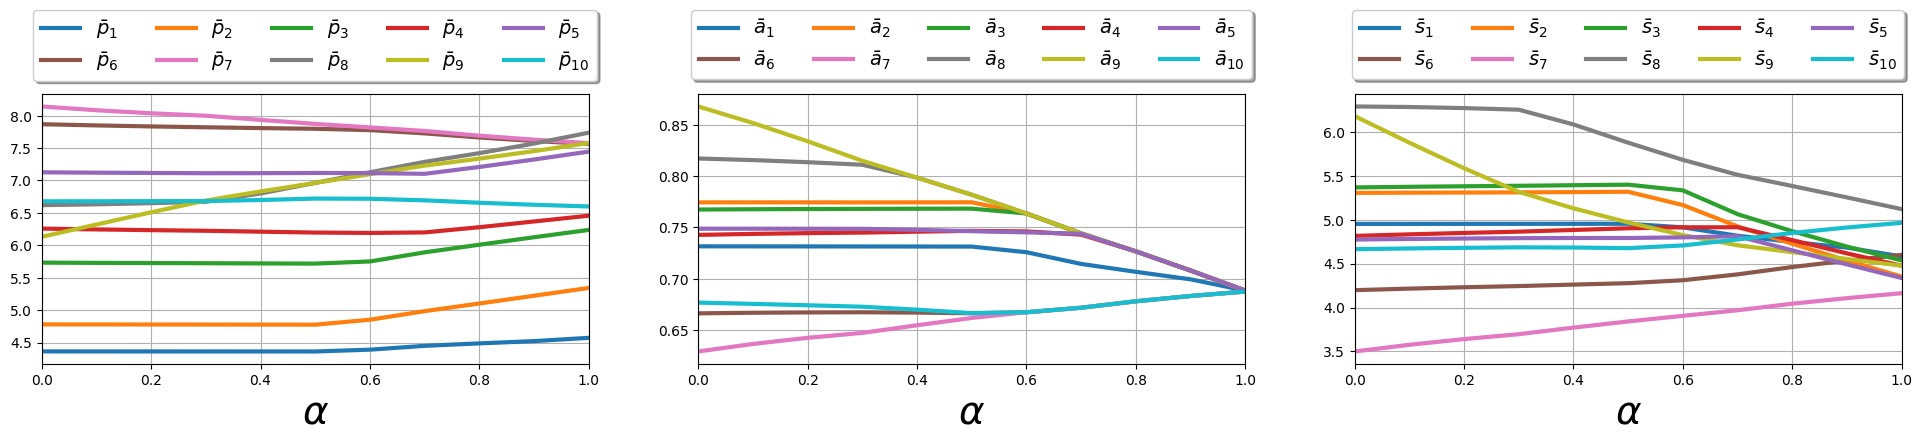

In [ ]:
# Figure 14
draw_average(weighted['a_i'], weighted['p_i'], surplus_list, total_surplus_list)

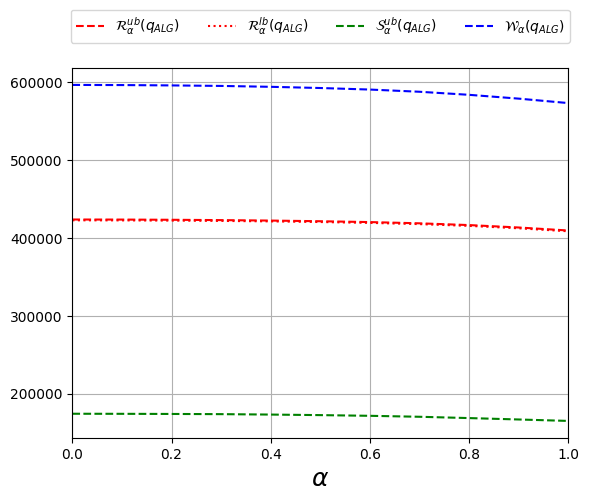

In [ ]:
draw_revenue(revenue_list, total_surplus_list, fairness='Access')

In [ ]:
# Table 1
revenue = revenue_list['lb']
tex = ''
for i in range(len(revenue)):
  t = str(round(revenue[i]/revenue[0]*100,2)) + '  '
  tex += t
print(tex)

tex = ''
for i in range(len(total_surplus_list)):
  t = str(round(total_surplus_list[i]/total_surplus_list[0]*100,2)) + '  '
  tex += t
print(tex)

tex = ''
welfare_list = [revenue[i]+total_surplus_list[i] for i in range(len(total_surplus_list))]
for i in range(len(welfare_list)):
  t = str(round(welfare_list[i]/welfare_list[0]*100,2)) + '  '
  tex += t
print(tex)

100.0  99.98  99.92  99.82  99.68  99.48  99.22  98.84  98.31  97.57  96.66  
100.0  99.94  99.84  99.7  99.39  98.99  98.47  97.76  96.79  95.76  94.7  
100.0  99.97  99.89  99.78  99.59  99.33  99.0  98.53  97.87  97.04  96.09  


<ipython-input-22-cad9e335381f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


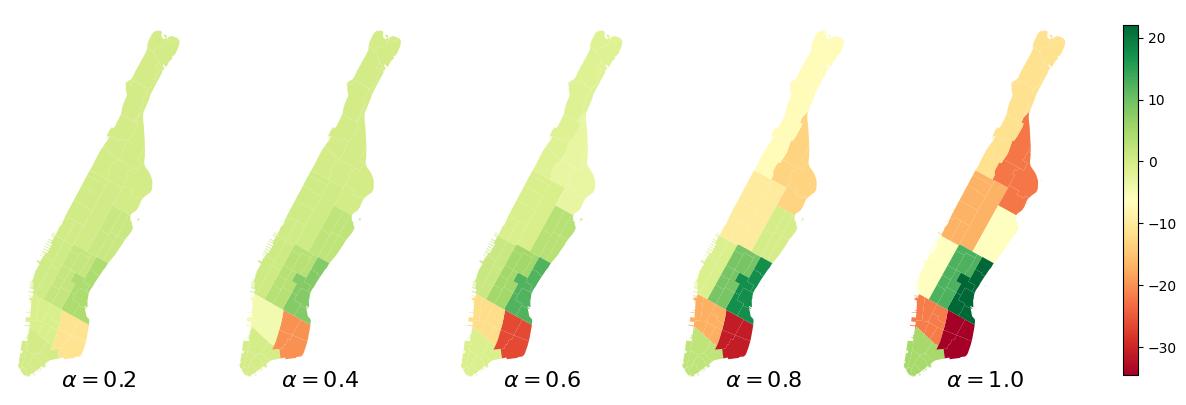

In [ ]:
# Figure 15
draw_heatmap(weighted)

<ipython-input-22-cad9e335381f>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


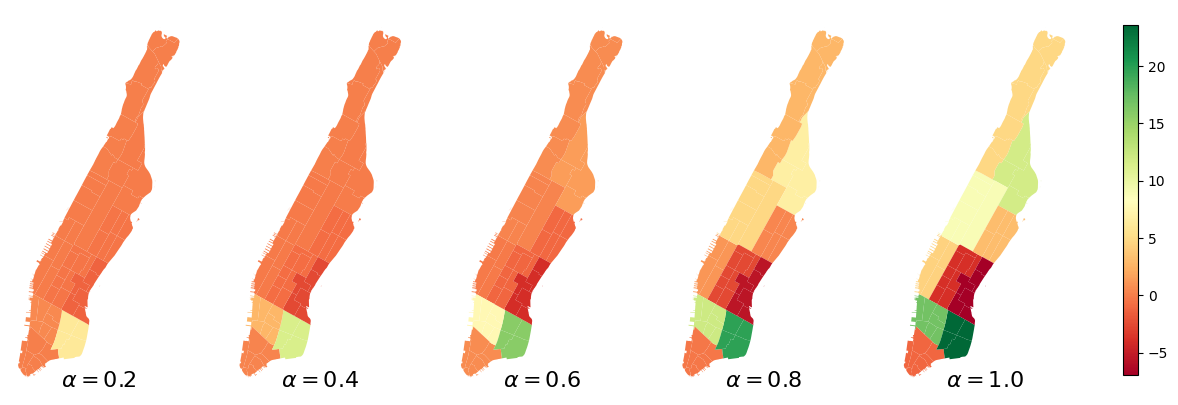

In [ ]:
draw_heatmap(weighted, target='price')

<ipython-input-23-2075b1b74a02>:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


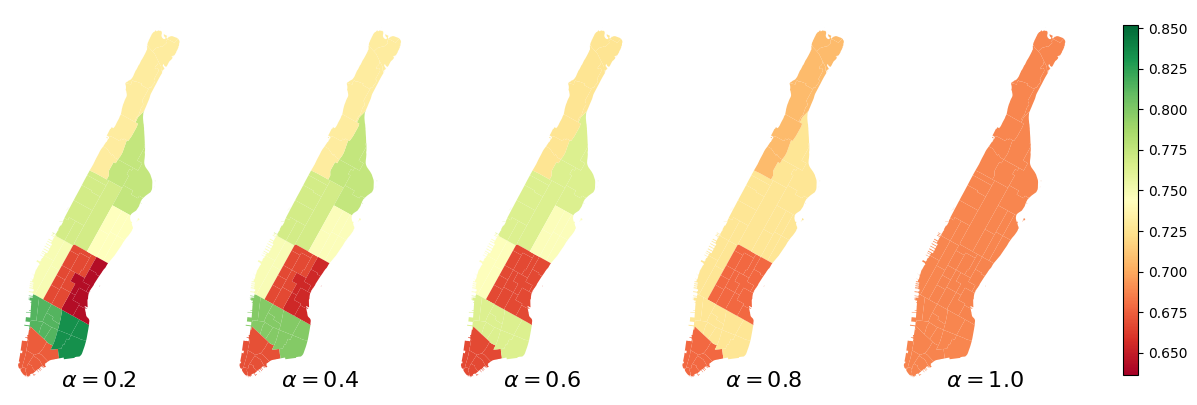

In [ ]:
draw_heatmap_absolute(weighted, target='access') # check whether access fairnes holds

## Price Fairness (Each)

In [ ]:
revenue_list, total_surplus_list, surplus_list, p_list, a_list, weighted = price_algorithm_simulator(param, fairness = 'Price', num_iter=500)

algorithm start
alpha 1.0
Elapsed time: 1.54 minutes
alpha 0.9
Elapsed time: 7.48 minutes
alpha 0.8
Elapsed time: 7.42 minutes
alpha 0.7
Elapsed time: 7.32 minutes
alpha 0.6
Elapsed time: 7.27 minutes
alpha 0.5
Elapsed time: 7.23 minutes
alpha 0.4
Elapsed time: 7.24 minutes
alpha 0.3
Elapsed time: 7.17 minutes
alpha 0.2
Elapsed time: 7.21 minutes
alpha 0.1
Elapsed time: 7.10 minutes
alpha 0.0
Elapsed time: 7.10 minutes


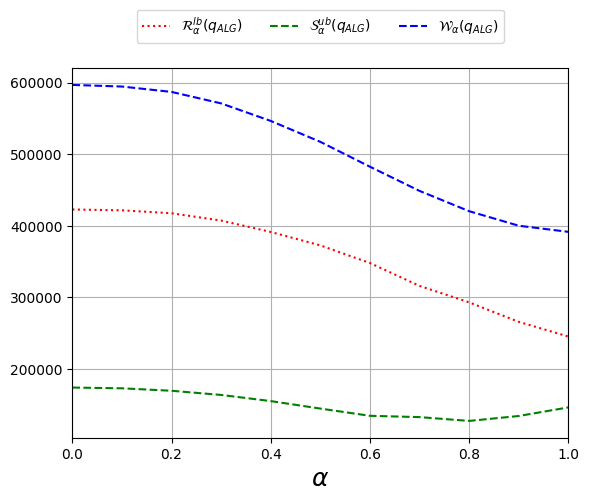

In [ ]:
draw_revenue(revenue_list, total_surplus_list, fairness='Price')

In [ ]:
# Table 2
revenue = revenue_list['lb']
tex = ''
for i in range(len(revenue)):
  t = str(round(revenue[i]/revenue[0]*100,2)) + '  '
  tex += t
print(tex)

tex = ''
for i in range(len(total_surplus_list)):
  t = str(round(total_surplus_list[i]/total_surplus_list[0]*100,2)) + '  '
  tex += t
print(tex)

tex = ''
welfare_list = [revenue[i]+total_surplus_list[i] for i in range(len(total_surplus_list))]
for i in range(len(welfare_list)):
  t = str(round(welfare_list[i]/welfare_list[0]*100,2)) + '  '
  tex += t
print(tex)

100.0  99.72  98.75  96.34  92.57  88.14  82.31  74.75  69.3  62.87  58.01  
100.0  99.39  97.41  94.07  89.13  83.12  77.31  76.27  73.21  77.17  84.06  
100.0  99.62  98.36  95.68  91.57  86.67  80.85  75.19  70.44  67.04  65.61  


<ipython-input-44-ed7742836194>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdYlGn_r')


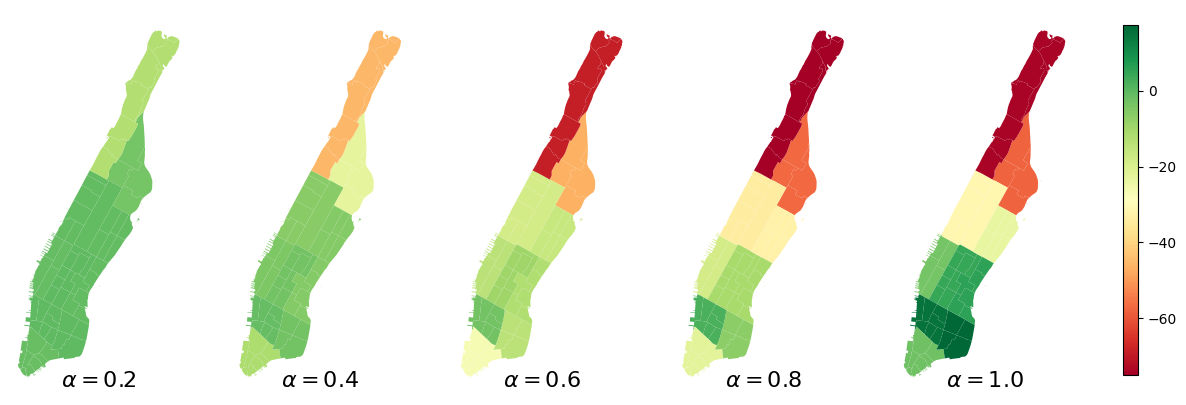

In [ ]:
# Figure 17
draw_heatmap(weighted)

<ipython-input-19-3b2dd2178cef>:51: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  fig.legend(handles=new_legend.legendHandles, bbox_to_anchor=(0.5, 1.03), loc='upper center', ncol=10, prop={"size": 18})  # Adjust font size


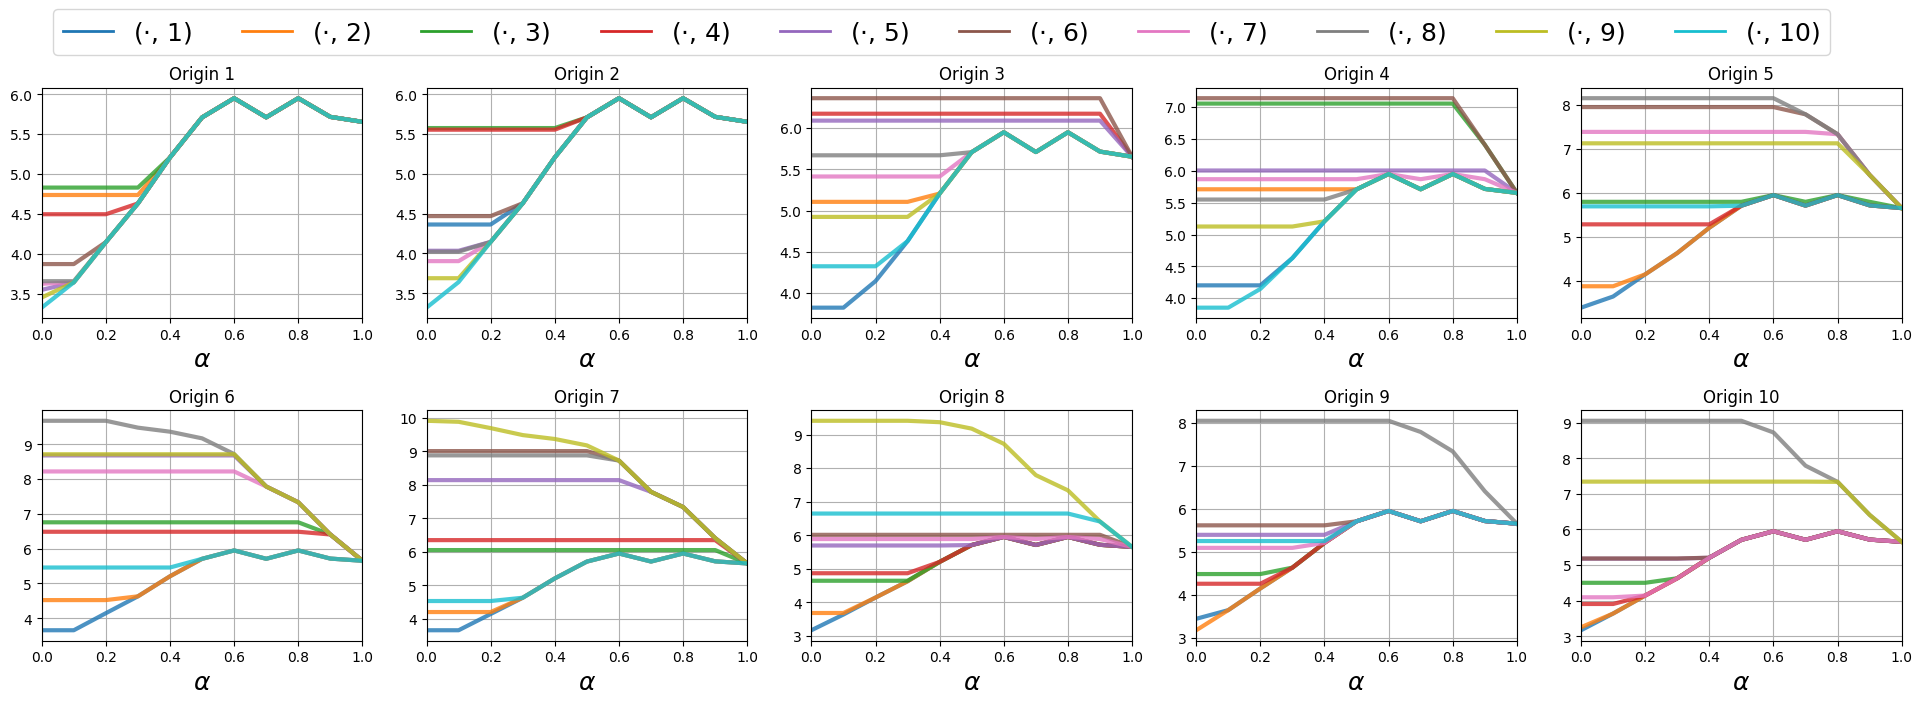

<Figure size 640x480 with 0 Axes>

In [ ]:
# Figure 16
subplot_price(p_list, param['d'])

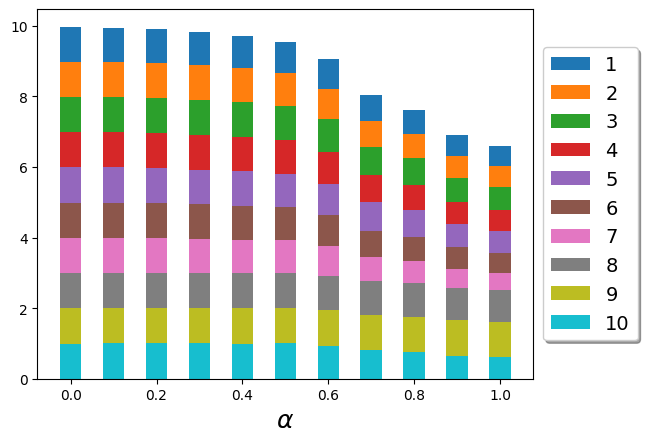

In [ ]:
# Figure 18
draw_pi(weighted['pi'])